# Прогнозирование оттока клиентов

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Цель проекта.** 

Целью проекта является разработка модели, прогнозирующей возможное прекращение сотрудничества клиента с оператором связи.

**План работ.**
1. Загрузка данных (первичная загрузка данных и анализ структуры данных).
2. Предобработка данных (изменение типов данных, обработка пропусков, добавление новых признаков объединение данных в одну таблицу).
3. Исследовательский анализ данных (анализ плотности распределений каждого из признаков, а также их статистических распределений, нахождение первичных взаимосвязей между признаками).
4. Подготовка данных (кодирование категориальных признаков, удаление неинформативных фичей) и обучение моделей.
5. Итоговое тестирование выбранной модели (тестирование наилучшей из моделей).
6. Выводы.

**Описание услуг.**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно;
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).


За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных.**

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

**Описание полей данных.**
- `BeginDate` – дата начала пользования услугами;
- `EndDate` – дата окончания пользования услугами;
- `Type` – тип оплаты: ежемесячный, годовой и тд;
- `PaperlessBilling` – безналичный расчет;
- `PaymentMethod` – способ оплаты;
- `MonthlyCharges` – ежемесячные траты на услуги;
- `TotalCharges` – всего потрачено денег на услуги;
- `Dependents` – наличие иждивенцев;
- `Senior Citizen` – наличие пенсионного статуса по возрасту;
- `Partner` – наличие супруга(и);
- `MultipleLines` – наличие возможности ведения параллельных линий во время звонка.

## 1. Загрузка данных и изучение общей информации

In [1]:
# установка используемых библиотек
!pip install phik                  
!pip install scikit-learn==1.1.3

Импорт необходимых библиотек

In [2]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from phik.report import plot_correlation_matrix 
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

Создадим несколько функций

In [3]:
def info(frame):               # вывод основной информации о наборе данных
    display(frame.head(5))
    frame.info()
    
def pie(feature, title):       # круговая диаграмма для категориальных признаков
    table = data.pivot_table(index=feature, 
                             values='CustomerID', 
                             aggfunc='count')
    table.plot(kind='pie', y='CustomerID', 
               figsize=(5,5), autopct='%1.0f%%')
    plt.ylabel('')
    plt.title(title)
    plt.legend(bbox_to_anchor=( 1 , 0.7 ))
    plt.show()

In [4]:
RANDOM_STATE = 50623           # константа для разделения данных и обучения моделей

In [5]:
warnings.filterwarnings('ignore')  # отключение предупреждений

Произведем загрузку исходных данных

In [6]:
try:
    contract = pd.read_csv('contract_new.csv')
    personal = pd.read_csv('personal_new.csv')
    internet = pd.read_csv('internet_new.csv')
    phone = pd.read_csv('phone_new.csv')
except:
    contract = pd.read_csv('/datasets/contract_new.csv')
    personal = pd.read_csv('/datasets/personal_new.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
    phone = pd.read_csv('/datasets/phone_new.csv')

### 1.1. Данные о договорах

Выведем основную информацию о договорах

In [7]:
info(contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


**Вывод:** требуется изменить название столбца `customerID` в `CustomerID`, привести признаки `BeginDate` и `EndDate` к типу даты, добавить несколько признаков: время, на протяжении которого действует (действовал) договор, и целевой признак, который указывает пользуется ли клиент услугами. Также необхожимо после всех преобразований проверить данные на идентичность. Пропусков нет.

### 1.2. Персональные данные клиентов

Теперь посмотрим на структуру персональных данных клиентов

In [8]:
info(personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


**Вывод:** необходимо изменить названия признаков `customerID` на `CustomerID` и `gender` на `Gender`, а также проверить данные на идентичность. Пропусков нет.

### 1.3. Информация об интернет-услугах

Посмотрим на данные об интернет-услугах, предоставляемых клиентам оператора связи

In [9]:
info(internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


**Вывод:** необходимо изменить название признака `customerID` на `CustomerID` , а также проверить данные на идентичность. Пропусков нет.

### 1.4. Информация об услугах телефонии

И, на конец, посмотрим на структуру данных об услугах телефонии

In [10]:
info(phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


**Вывод:** необходимо изменить название признака `customerID` на `CustomerID` , а также проверить данные на идентичность. Пропусков нет.

**ИТОГ.** В ходе первого этапа проекта загрузили данные и просмотрели структуру каждых из четырех датасетов.

## 2. Предобработка данных

### 2.1. Данные о договрах

Еще раз приведем общую информацию о наборе данных. 

In [11]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Переименуем столбец `customer_ID` в `Customer_ID` для поддержания единого формата обозначения признаков.

In [12]:
contract = contract.rename(columns={'customerID' : 'CustomerID'})
contract.head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


Добавим два дополнительных признака в данные о договорах:
- `Duration` - время, на протяжении которого действует (действовал) договор;
- `Termination` - принимает значение 1, если клиент отказался от услуг, или 0, если клиент до сих пор пользуется услугами оператора связи.
Начнем с `Termination`

In [13]:
contract['Termination'] = (contract['EndDate'] != 'No').astype('int')
contract.head(10)

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Termination
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,0
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,0
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,0
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,0
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,1


Значение `No` в столбце `EndDate` означает, что клиент еще пользуется услугами оператора связи. Т.к. данные актуальны на 1 февраля 2020, то заменим значение 'No' на эту дату.

In [14]:
contract['EndDate'] = contract['EndDate'].replace(['No'], ['2020-02-01'])
print('Число неисправленных записей:', contract['EndDate'][contract['EndDate'] == 'No'].count())

Число неисправленных записей: 0


Изменим тип данных в столбцах `BeginDate` и `EndDate` на дату

In [15]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d')
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   Termination       7043 non-null   int32         
dtypes: datetime64[ns](2), float64(1), int32(1), object(5)
memory usage: 467.8+ KB


Изменим тип данных у признака `TotalCharges`

In [16]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   Termination       7043 non-null   int32         
dtypes: datetime64[ns](2), float64(2), int32(1), object(4)
memory usage: 467.8+ KB


При изменении типа данных появились пропуски. Посмотрим на строки, где находятся эти пропуски

In [17]:
contract[contract['TotalCharges'].isna()]

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Termination
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0


Видим, что пропуски в поле `TotalCharges` есть только у тех пользователей, которые только начали пользоваться услугами и, соответственно, видимо не успели потратить деньги на услуги. Заполним эти пропуски нулем.

In [18]:
contract['TotalCharges'] = contract['TotalCharges'].fillna(0)
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Termination       7043 non-null   int32         
dtypes: datetime64[ns](2), float64(2), int32(1), object(4)
memory usage: 467.8+ KB


Добавим теперь признак `Duration`, описанный ранее

In [19]:
contract['Duration'] = (contract['EndDate'] - contract['BeginDate']).dt.days
contract.head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Termination,Duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153


Проверим данные на дубликаты

In [20]:
print('Количество дубликатов в данных:', contract.duplicated().sum())

Количество дубликатов в данных: 0


### 2.2. Персональные данные клиента

Еще раз приведем общую информацию о наборе данных. 

In [21]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Пропусков в данных нет. Переименуем столбец `customer_ID` в `Customer_ID`, а `gender` в `Gender` для поддержания единого формата обозначения признаков.

In [22]:
personal = personal.rename(columns={'customerID' : 'CustomerID', 'gender' : 'Gender'})
personal.head()

,CustomerID,Gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Проверим данные на дубликаты

In [23]:
print('Количество дубликатов в данных:', personal.duplicated().sum())

Количество дубликатов в данных: 0


Изменим тип данных в признаке `SeniorCitizen`

In [24]:
personal['SeniorCitizen'] = personal['SeniorCitizen'].astype('str')
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     7043 non-null   object
 1   Gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


### 2.3. Информация об интернет-услугах

Еще раз приведем общую информацию о наборе данных. 

In [25]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Пропусков в данных нет. Переименуем столбец `customer_ID` в `Customer_ID` для поддержания единого формата обозначения признаков.

In [26]:
internet = internet.rename(columns={'customerID' : 'CustomerID'})
internet.head()

,CustomerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Проверим данные на дубликаты

In [27]:
print('Количество дубликатов в данных:', internet.duplicated().sum())

Количество дубликатов в данных: 0


### 2.4. Информация об услугах телефонии

Еще раз приведем общую информацию о наборе данных. 

In [28]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Пропусков в данных нет. Переименуем столбец customer_ID в Customer_ID для поддержания единого формата обозначения признаков.

In [29]:
phone = phone.rename(columns={'customerID' : 'CustomerID'})
phone.head()

,CustomerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Проверим данные на дубликаты

In [30]:
print('Количество дубликатов в данных:', internet.duplicated().sum())

Количество дубликатов в данных: 0


### 2.5. Объединение данных

Объединим все таблицы по признаку `CustomerID`

In [31]:
data = contract.merge(personal, how='left', on='CustomerID')\
               .merge(internet, how='left', on='CustomerID')\
               .merge(phone, how='left', on='CustomerID')

In [32]:
info(data)

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Termination,Duration,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,...,No,No,Fiber optic,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Termination       7043 non-null   int32         
 9   Duration          7043 non-null   int64         
 10  Gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   object        
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  InternetService   5517 n

В данных появились пропуски. Это произошло от того, что некоторые клиенты не пользовались услугами интернета или телефонии. Можем эти пропуски заполнить значением `No`.

In [33]:
data = data.fillna('No')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Termination       7043 non-null   int32         
 9   Duration          7043 non-null   int64         
 10  Gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   object        
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  InternetService   7043 n

Добавим еще один признак `ServicesNumber` показывающий количество дополнительных услуг, которыми пользовался (пользуется) клиент

In [34]:
services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', # массив с названиями услуг
            'StreamingTV', 'StreamingMovies', 'MultipleLines']

In [35]:
numb = []
numb = np.array([0 for i in range(data.shape[0])])
for serv in services:    
    numb += np.array(data[serv].replace({'Yes':1, 'No':0}))
data['ServicesNumber'] = numb

In [36]:
info(data)

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Termination,Duration,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ServicesNumber
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,...,No,DSL,No,Yes,No,No,No,No,No,1
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036,...,No,DSL,Yes,No,Yes,No,No,No,No,2
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,...,No,DSL,Yes,Yes,No,No,No,No,No,2
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,...,No,DSL,Yes,No,Yes,Yes,No,No,No,3
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,...,No,Fiber optic,No,No,No,No,No,No,No,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Termination       7043 non-null   int32         
 9   Duration          7043 non-null   int64         
 10  Gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   object        
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  InternetService   7043 n

**ИТОГ.**
В ходе предобработки данных были проделаны следующие работы:
1. Исправлены обозначения некоторых признаков;
2. В данных о договорах в столбцах `BeginDate` и `EndDate` данные были приведены к типу даты;
3. Данные были проверены на дубликаты;
4. Все 4 датасета были объединены в одну таблицу по признаку `CustomerID`;
5. Были обработаны пропуски в данных;
6. Добавлены новые признаки.

## 3. Исследовательский анализ данных

### 3.1. Категориальные признаки

Исследовательский анализ данных начнем категориальных признаков.

Взглянем, какой тип оплаты преобладает

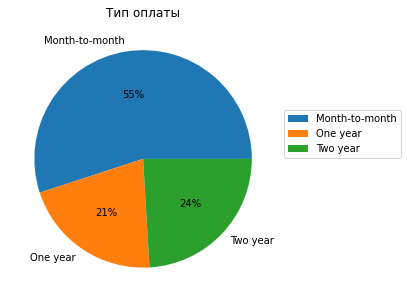

In [37]:
pie('Type', 'Тип оплаты')

Преобладает ежемесячный тип оплаты(55%), затем идет двухгодовая оплата (24%) и замыкает топ годовая оплата (21%). Посмотрим, есть ли у клиентов электронный плтежный документ.

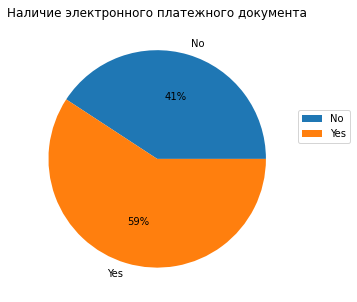

In [38]:
pie('PaperlessBilling', 'Наличие электронного платежного документа')

У 41% клиентов нет электронного платежного документа. Узнаем, какими способами оплаты пользуются клиенты

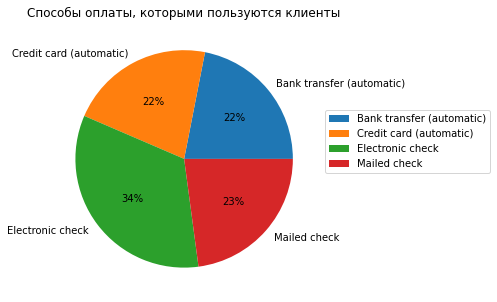

In [39]:
pie('PaymentMethod', 'Способы оплаты, которыми пользуются клиенты')

Большинство клиентов (33%) выбирают электронный чек, как способ опдаты

Посмотрим на распределение целевого признака.

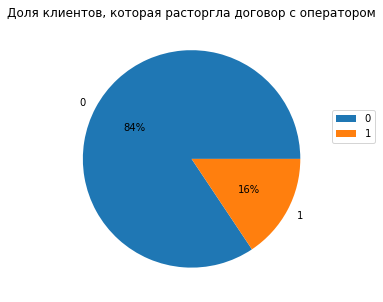

In [40]:
pie('Termination', 'Доля клиентов, которая расторгла договор с оператором')

Видим, что 84% всех клиентов до сих пор пользуются услугами оператора. При этом 16% решили прекратить сотрудничество с оператором. Так же можно сказать, что заметен дисбаланс классов в данном признаке.

Посмотрим на соотношение мужчин и женщин в клиентской базе.

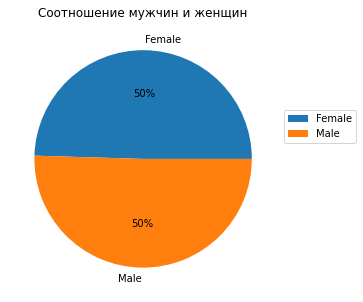

In [41]:
pie('Gender', 'Соотношение мужчин и женщин')

Как видим 50 на 50. Посмотрим, какая часть клиентов имеет супруга(у)

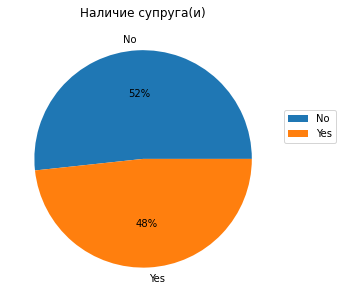

In [42]:
pie('Partner', 'Наличие супруга(и)')

Чуть большая часть клиентов (52%) не имеет семейной пары. Что же нам скажет диаграмма о наличии или отсутствии иждивенцев

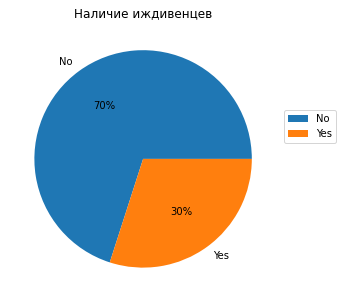

In [43]:
pie('Dependents', 'Наличие иждивенцев')

70% всех клиентов не имеют иждивенцев. Теперь посмотрим на то, каким образом подключен интернет у пользователей.

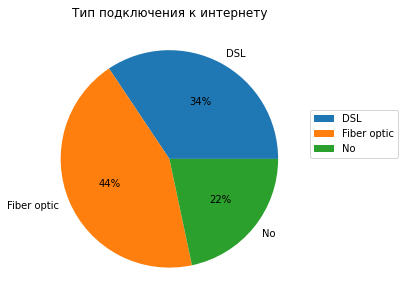

In [44]:
pie('InternetService', 'Тип подключения к интернету')

44% процента клиентов подключают интернет по оптоволоконному кабелю, а 34% - по телефонной линии. При этом 22% клиентов вовсе не имеют интернет-подключения. Рассмотрим использование клиентами тех или иных интернет-услуг.

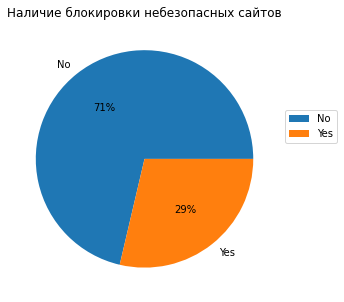

In [45]:
pie('OnlineSecurity', 'Наличие блокировки небезопасных сайтов')

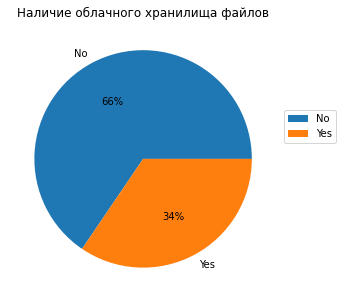

In [46]:
pie('OnlineBackup', 'Наличие облачного хранилища файлов')

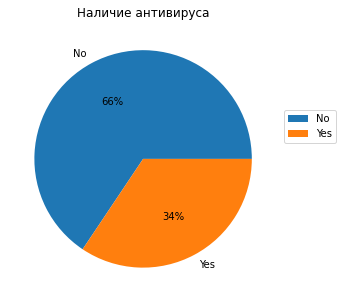

In [47]:
pie('DeviceProtection', 'Наличие антивируса')

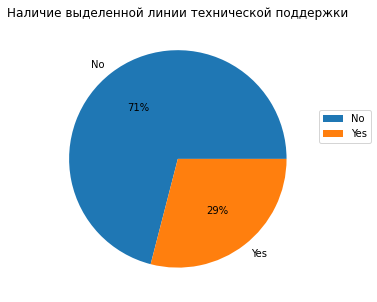

In [48]:
pie('TechSupport', 'Наличие выделенной линии технической поддержки')

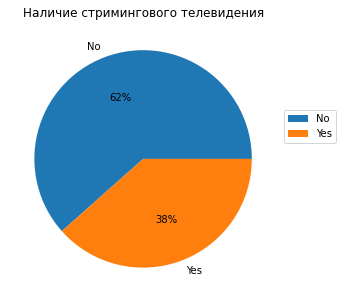

In [49]:
pie('StreamingTV', 'Наличие стримингового телевидения')

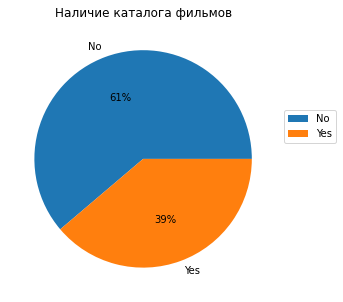

In [50]:
pie('StreamingMovies', 'Наличие каталога фильмов')

По итогу анализа использования клиентами интернет-услуг сделаем промежуточные выводы:
1. только 29% пользователей имеют блокировку небезопасных сайтов; 
2. пользуются облачным хранилищем 34% клиентов;
3. 34% клиентов используют антивирус;
4. у 29% пользователей есть доступ к выделенной линии технической поддержки;
5. стриминговое телевидение и каталог фильмов имеют, соответственно, 38% и 39%.

### 3.2. Количественные признаки

Теперь посмотрим на распределение количественные признаков. Начнем с ежемесячных трат клиентов.

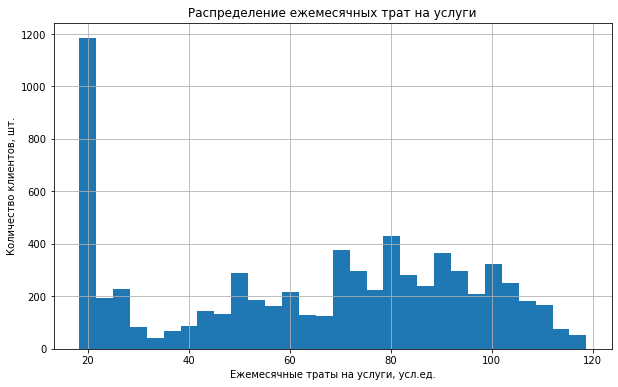

In [51]:
plt.figure(figsize=(10,6))
data['MonthlyCharges'].hist(bins=30)
plt.title('Распределение ежемесячных трат на услуги')
plt.xlabel('Ежемесячные траты на услуги, усл.ед.')
plt.ylabel('Количество клиентов, шт.')
plt.show()

Как видим, большинство клиентов пользуются недорогими услугами и тратят на это в месяц около 20 условных единиц.

In [52]:
data['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

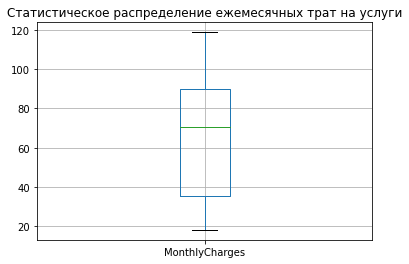

In [53]:
data.boxplot(column='MonthlyCharges')
plt.title('Статистическое распределение ежемесячных трат на услуги')
plt.show()

Так же можно сказать, что минимальные ежемесячные траты составляют 18.25 усл.ед., а максимальные - 118.75. При этом в среднем клиенты в месяц тратят около 65 усл.ед.

Проведем аналогичное исследование над общими тратами клиентов на услуги.

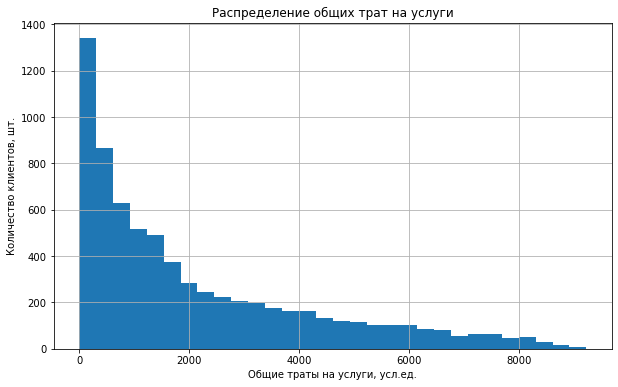

In [54]:
plt.figure(figsize=(10,6))
data['TotalCharges'].hist(bins=30)
plt.title('Распределение общих трат на услуги')
plt.xlabel('Общие траты на услуги, усл.ед.')
plt.ylabel('Количество клиентов, шт.')
plt.show()

Распределение общих трат на услуги подчинено экспоненциальному распределению. Большинство клиентов в общей сумме потратили не более 2000 усл.ед.

In [55]:
data['TotalCharges'].describe()

count    7043.000000
mean     2115.312885
std      2112.742814
min         0.000000
25%       436.750000
50%      1343.350000
75%      3236.690000
max      9221.380000
Name: TotalCharges, dtype: float64

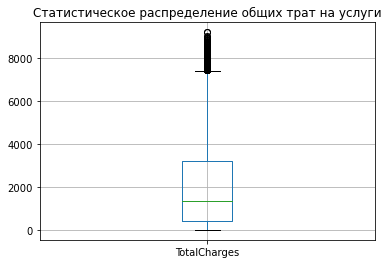

In [56]:
data.boxplot(column='TotalCharges')
plt.title('Статистическое распределение общих трат на услуги')
plt.show()

Есть клиенты, которые пока не потратили ничего. Самые максимальные общие траты составляют 9221 усл.ед. В среднем клиенты на данный момент потратили 2115 усл.ед.

Посмотрим, как распределено время, на протяжении которого клиенты пользуются услугами оператора

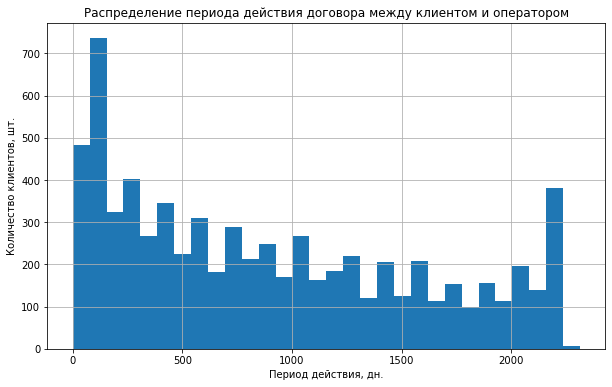

In [57]:
plt.figure(figsize=(10,6))
data['Duration'].hist(bins=30)
plt.title('Распределение периода действия договора между клиентом и оператором')
plt.xlabel('Период действия, дн.')
plt.ylabel('Количество клиентов, шт.')
plt.show()

Большинство договоров имеют период действия от нескольких дней до полугода. Затем идет постепенный спад

In [58]:
data['Duration'].describe()

count    7043.000000
mean      898.555729
std       683.130510
min         0.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: Duration, dtype: float64

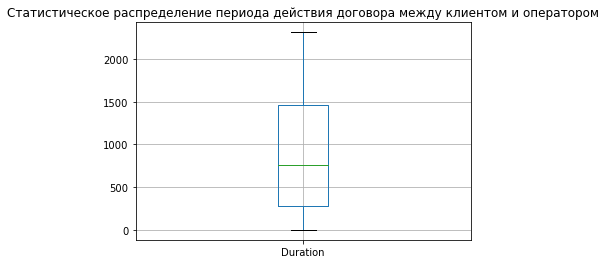

In [59]:
data.boxplot(column='Duration')
plt.title('Статистическое распределение периода действия договора между клиентом и оператором')
plt.show()

Видим, что есть договоры, которые только что были заключены на момент актуальности данных. Есть и такие, которые достигли времени действия 2314 дней (6.5 лет). В среднем, на момент актуальности данных, средней продолжительностью действия договора является 898 дней (примерно 2.5 года)

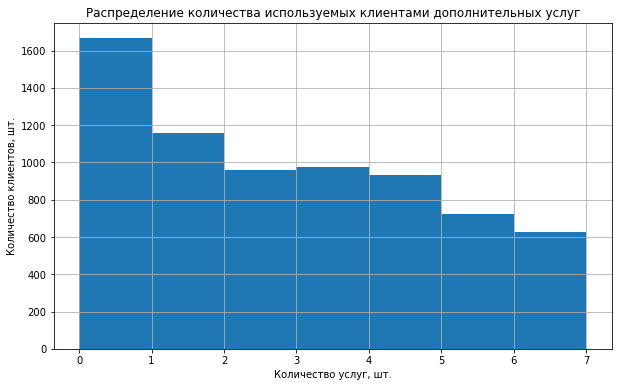

In [60]:
plt.figure(figsize=(10,6))
data['ServicesNumber'].hist(bins=7)
plt.title('Распределение количества используемых клиентами дополнительных услуг')
plt.xlabel('Количество услуг, шт.')
plt.ylabel('Количество клиентов, шт.')
plt.show()

Из распределения видно, что большиенство клиентов не пользуются дополнительными услугами оператора. Затем, по мере увеличения количества услуг, число клиентов, пользующихся ими, уменьшается

### 3.3. Взаимосвязи признаков

Посмотрим на корреляцию признаков.

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'Termination', 'Duration', 'ServicesNumber']


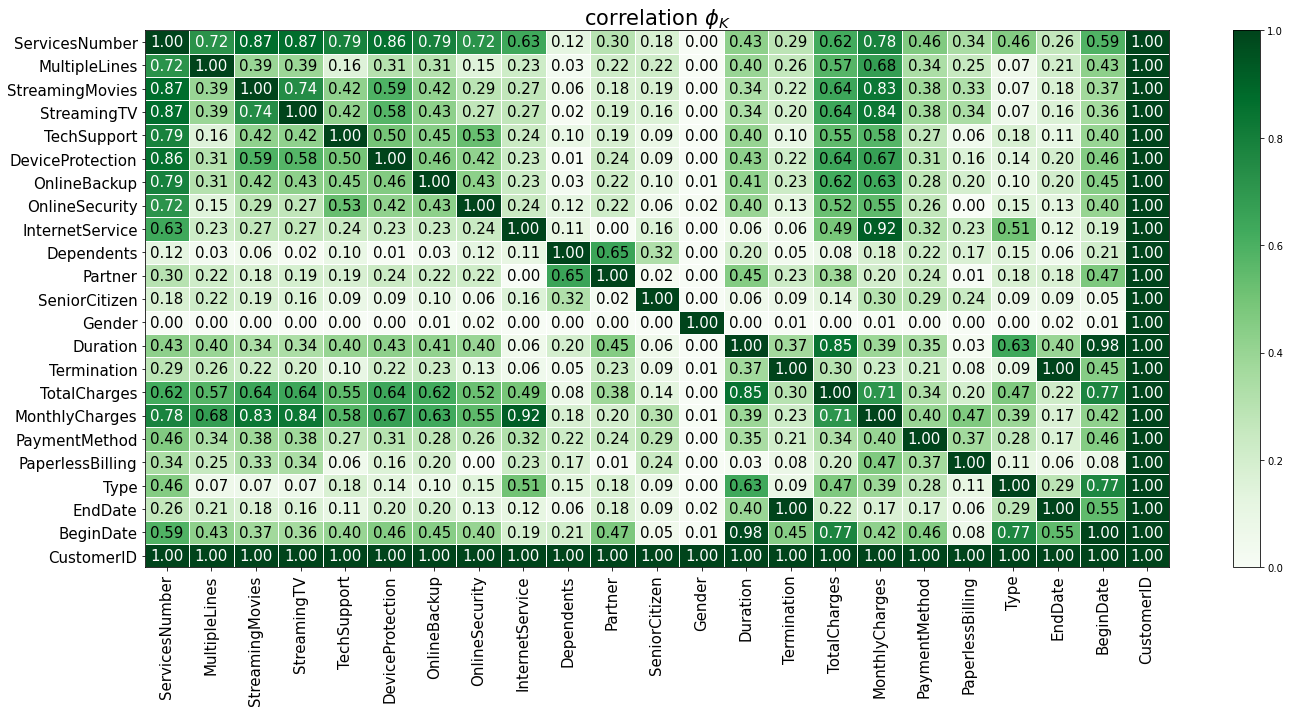

In [61]:
phik_overview = data.phik_matrix() 
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", fontsize_factor=1.5, figsize=(20, 10)) 
plt.tight_layout()

Признак `CustomerID` на этапе подготовки данных к обучению моделей сделаем индексом наших данных, т.к. он ни на что не влияет, а только указывает на идентичность записи. Признак `BeginDate` коррелирует с признаком `Duration` (это логично, т.к. договоры, которые были раньше заключены и не расторгались, на актуальную дату имеют больший период действия). Признак `EndDate` коррелирует с признаком `Termination` из-за заполнения пропусков в столбце `EndDate` актуальной датой выгрузки данных. Т.к. из признаков `BeginDate` и `EndDate` мы извлекли нужную нам информацию и поместили ее в признак `Duration`, то эти два столбца не являются информативными и мы их также удалим на этапе подготовки данных к обучению моделей.

Как видно из тепловой карты, корреляция признаков `MonthlyCharges` и `TotalCharges` с признаками различных услуг оператора выглядет логичной. Признак `Gender` также удалим далее из-за его неинформативности.

Посмотрим на зависимость между некоторыми признаками и целевым признаком `Termination`. Начнем с количества дополнительных услуг, которыми пользуются (пользовались) клиенты.

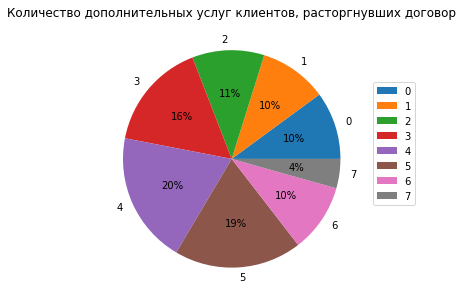

In [62]:
table = data.query('Termination == 1').pivot_table(index='ServicesNumber', values='Termination', aggfunc='count')
table.plot(kind='pie', y='Termination', figsize=(5,5), autopct='%1.0f%%')
plt.ylabel('')
plt.title('Количество дополнительных услуг клиентов, расторгнувших договор')
plt.legend(bbox_to_anchor=( 1 , 0.8 ))
plt.show()

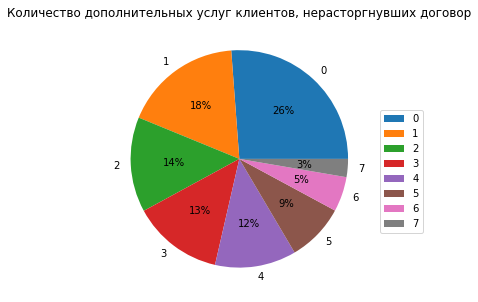

In [63]:
table = data.query('Termination == 0').pivot_table(index='ServicesNumber', values='Termination', aggfunc='count')
table.plot(kind='pie', y='Termination', figsize=(5,5), autopct='%1.0f%%')
plt.ylabel('')
plt.title('Количество дополнительных услуг клиентов, нерасторгнувших договор')
plt.legend(bbox_to_anchor=( 1 , 0.7 ))
plt.show()

Среди тех, кто расторг договор, больше клиентов с 4 и 5 дополнительными услугами, чуть меньше с 3. Если брать тех, кто еще пользуюется данным оператором, то тут больше клиентов, которые вообще не пользуются дополнительными услугами (26%).

Рассмотрим влияние признака наличия партнера на факт прекращения сотрудничества с оператором.

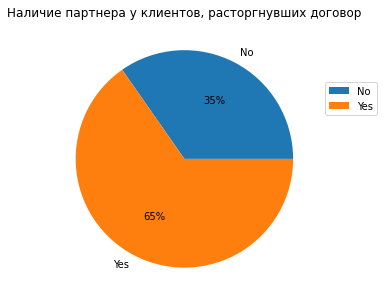

In [64]:
table = data.query('Termination == 1').pivot_table(index='Partner', values='Termination', aggfunc='count')
table.plot(kind='pie', y='Termination', figsize=(5,5), autopct='%1.0f%%')
plt.ylabel('')
plt.title('Наличие партнера у клиентов, расторгнувших договор')
plt.legend(bbox_to_anchor=( 1 , 0.8 ))
plt.show()

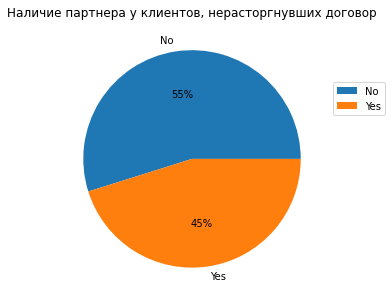

In [65]:
table = data.query('Termination == 0').pivot_table(index='Partner', values='Termination', aggfunc='count')
table.plot(kind='pie', y='Termination', figsize=(5,5), autopct='%1.0f%%')
plt.ylabel('')
plt.title('Наличие партнера у клиентов, нерасторгнувших договор')
plt.legend(bbox_to_anchor=( 1 , 0.8 ))
plt.show()

Как видим, среди тех, кто отказался от сотрудничества с оператором, 65% клиентов имеют партнера. При этом только 45% клиентов, расторгнувших договор, имеют партнера.

Посмотрим на зависимость целевого признака от срока действия договора.

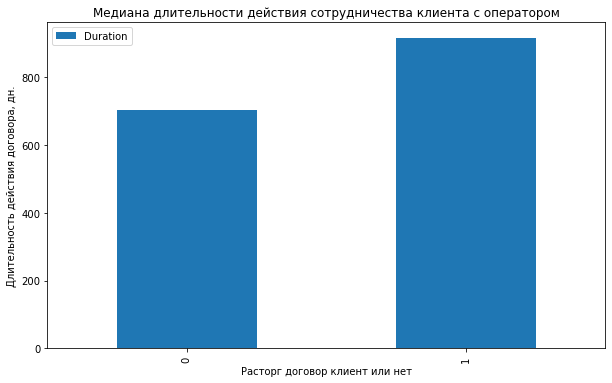

In [66]:
tbl = data.pivot_table(index='Termination', values='Duration', aggfunc='median').reset_index()
tbl.plot(x='Termination', y='Duration', kind='bar', figsize=(10,6))
plt.title('Медиана длительности действия сотрудничества клиента с оператором')
plt.xlabel('Расторг договор клиент или нет')
plt.ylabel('Длительность действия договора, дн.')
plt.show()

Для отслеживания зависимости взяли медиану, т.к. она не чувствительна к аномалиям в данных. Видим, что медиана периода сотрудничества клиентов, нерасторгнувших договор, составляет примерно 700 дней или почти 2 года. Если говорить о клиентах, которые прекратили свое сотрудничество с оператором, то здесь медианное значение длительности сотрудничества составляет более 800 дней.

Теперь проследим, как ежемесячные траты клиентов связаны с фактом расторжения договра.

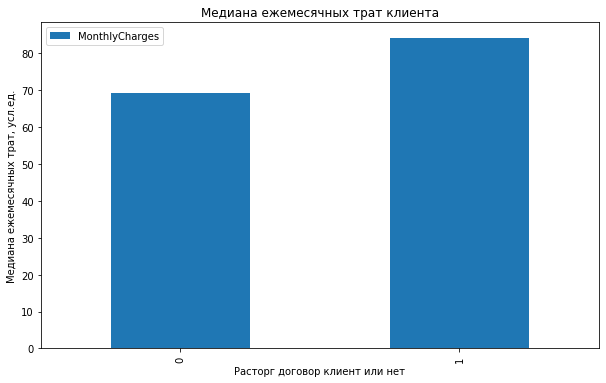

In [67]:
tbl = data.pivot_table(index='Termination', values='MonthlyCharges', aggfunc='median').reset_index()
tbl.plot(x='Termination', y='MonthlyCharges', kind='bar', figsize=(10,6))
plt.title('Медиана ежемесячных трат клиента')
plt.xlabel('Расторг договор клиент или нет')
plt.ylabel('Медиана ежемесячных трат, усл.ед.')
plt.show()

Медиана ежемесячных трат клиентов, которые расторгли контракт, находилась на уровне 80 усл.ед. Если брать тех, кто продолжает сотрудничество с оператором, то у них медиана ежемесячных трат на уровне 70 усл.ед.

Посмотрим, как обстоят дела с общими тратами

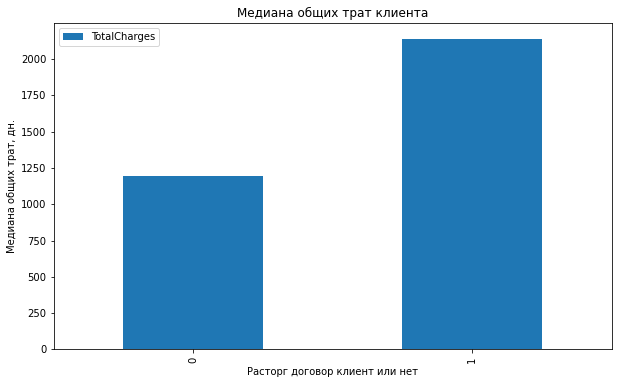

In [68]:
tbl = data.pivot_table(index='Termination', values='TotalCharges', aggfunc='median').reset_index()
tbl.plot(x='Termination', y='TotalCharges', kind='bar', figsize=(10,6))
plt.title('Медиана общих трат клиента')
plt.xlabel('Расторг договор клиент или нет')
plt.ylabel('Медиана общих трат, дн.')
plt.show()

Здесь заметен значительно различие медиан общих трат клиентов, расторгнувших договор (около 2000 усл.ед.) и тех, кто еще продолжает сотрудничество с оператором (около 1250 усл.ед.)

**ИТОГ.** В ходе исследовательского анализа мы:
- посмотрели распределение каждого столбца данных;
- составли матрицу корреляции признаков;
- проанализировали зависимоть между целевым признаком и некоторыми другим фичами

## 4. Подготовка данных и обучение моделей

Сделаем из столбца `CustomerID` индекс набора данных

In [69]:
data.index = data['CustomerID']
data = data.drop(columns=['CustomerID'], axis=1)
data.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Termination,Duration,Gender,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ServicesNumber
CustomerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,...,No,DSL,No,Yes,No,No,No,No,No,1
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036,Male,...,No,DSL,Yes,No,Yes,No,No,No,No,2
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,...,No,DSL,Yes,Yes,No,No,No,No,No,2
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,...,No,DSL,Yes,No,Yes,Yes,No,No,No,3
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,...,No,Fiber optic,No,No,No,No,No,No,No,0


Также удалим из данных такие признаки, как `BeginDate`, `EndDate`, `Gender`

In [70]:
data = data.drop(columns=['BeginDate', 'EndDate', 'Gender'], axis=1)
data.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Termination,Duration,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ServicesNumber
CustomerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,0,Yes,No,DSL,No,Yes,No,No,No,No,No,1
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036,0,No,No,DSL,Yes,No,Yes,No,No,No,No,2
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,0,No,No,DSL,Yes,Yes,No,No,No,No,No,2
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,3
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,0,No,No,Fiber optic,No,No,No,No,No,No,No,0


Посмотрим, есть дисбаланс классов в целевой переменной

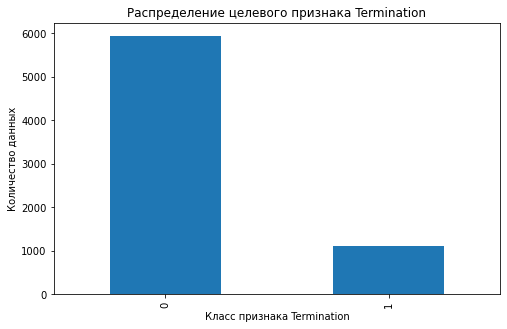

In [71]:
data['Termination'].value_counts().plot(kind='bar', figsize=(8,5))
plt.title('Распределение целевого признака Termination')
plt.xlabel('Класс признака Termination')
plt.ylabel('Количество данных')
plt.show()

Видим явный дисбаланс классов. Т.к. у нас в качестве метрики выбора наилучшей модели будет AUC-ROC, то проблема дисбаланса классов нас особо не волнует.

Разделим данные на тренировочную и тестовую выборки.

In [72]:
train, test = train_test_split(data, test_size=0.25, random_state=RANDOM_STATE, stratify=data['Termination'])
print(train.shape, test.shape)

(5282, 19) (1761, 19)


Выделим обычные и целевой признаки данных.

In [73]:
features_train = train.drop(['Termination'], axis=1)
features_test = test.drop(['Termination'], axis=1)
target_train = train['Termination']
target_test = test['Termination']

Приступим к стандартизации количественных признаков и кодированию категориальных. Для этого создадим списки с категориальными и количественными признаками.

In [74]:
cat = ['Type', 'PaperlessBilling', 'PaymentMethod', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
      'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
num = ['MonthlyCharges', 'TotalCharges', 'Duration', 'ServicesNumber']

Сделаем стандартизацию количественных признаков и кодирование категориальных признаков, а затем обучим модели. Начнем с логистической регрессии.

In [75]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False), cat),
    ('num', StandardScaler(), num)
])

pipe_regr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(random_state=RANDOM_STATE))
])

param_grid = {'model__penalty':[None, 'l2', 'l1', 'elasticnet'],
              'model__C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid_regr = GridSearchCV(pipe_regr, param_grid, cv=5, scoring='roc_auc')
grid_regr.fit(features_train, target_train)
regr_auc = round(grid_regr.best_score_, 3)
print('Наилучшая конфигурация модели:', grid_regr.best_params_)
print('Наилучшее значение метрики AUC-ROC:', grid_regr.best_score_)

Наилучшая конфигурация модели: {'model__C': 1, 'model__penalty': 'l2'}
Наилучшее значение метрики AUC-ROC: 0.7628457455047413


Логистическая регрессия на тренировочной выборке показала значение метрики AUC-ROC 0.76 при следующих гиперпараметрах: С=1, penalty = 'l2'. Перейдем к дереву решений.

In [76]:
pipe_decis = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = {'model__max_depth':range(1,50),
              'model__min_samples_split':range(0, 4), 
              'model__min_samples_leaf':range(0,4)}

grid_dec = GridSearchCV(pipe_decis, param_grid, cv=5, scoring='roc_auc')
grid_dec.fit(features_train, target_train)
decis_auc = round(grid_dec.best_score_, 3)
print('Наилучшая конфигурация модели:', grid_dec.best_params_)
print('Наилучшее значение метрики AUC-ROC:', grid_dec.best_score_)

Наилучшая конфигурация модели: {'model__max_depth': 5, 'model__min_samples_leaf': 3, 'model__min_samples_split': 2}
Наилучшее значение метрики AUC-ROC: 0.7877411958433505


Наилучшую метрику показало дерево решений с гиперпараметрами max_depth=5, min_samples_leaf=3, min_samples_split=2 (AUC-ROC = 0.79). Подберем наилучшую конфигурацию для случайного леса.

In [77]:
pipe_forest = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=RANDOM_STATE))
])

param_grid = {'model__n_estimators':range(1, 200, 10),
              'model__max_depth':range(1, 20)}

grid_forest = GridSearchCV(pipe_forest, param_grid, cv=5, scoring='roc_auc')
grid_forest.fit(features_train, target_train)
forest_auc = round(grid_forest.best_score_, 3)
print('Наилучшая конфигурация модели:', grid_forest.best_params_)
print('Наилучшее значение метрики AUC-ROC:', grid_forest.best_score_)

Наилучшая конфигурация модели: {'model__max_depth': 10, 'model__n_estimators': 191}
Наилучшее значение метрики AUC-ROC: 0.818283809181868


Здесь метрика AUC-ROC = 0.82 (max_depth=9, n_estimators=181). Перейдем к бустинговым моделям. Сначала рассмотрим CatBoost

In [78]:
preproc = ColumnTransformer([
    ('num', StandardScaler(), num)
])

pipe_catb = Pipeline([
    ('model', CatBoostClassifier(random_state=RANDOM_STATE))
])

param_grid = {'model__learning_rate':[0.2, 0.3, 0.4],
              'model__iterations':range(200, 501, 25)}

grid_cat = GridSearchCV(pipe_catb, param_grid, cv=5, scoring='roc_auc')
grid_cat.fit(features_train, target_train, model__verbose=False, model__cat_features=cat)
cat_auc = round(grid_cat.best_score_, 3)
print('Наилучшая конфигурация модели:', grid_cat.best_params_)
print('Наилучшее значение метрики AUC-ROC:', grid_cat.best_score_)

Наилучшая конфигурация модели: {'model__iterations': 500, 'model__learning_rate': 0.2}
Наилучшее значение метрики AUC-ROC: 0.9062671700122549


Данная модель показала метрику AUC-ROC 0.9 с гиперпараметрами iterations=500 и learning_rate=0.2. Наконец рассмотрим модель LightGBM

In [79]:
features_train[cat] = features_train[cat].astype('category')
preproc = ColumnTransformer([
    ('num', StandardScaler(), num)
])

pipe_lgbm = Pipeline([
    ('model', LGBMClassifier(random_state=RANDOM_STATE))
])

param_grid = {'model__num_leaves':range(1,31, 2),
              'model__n_estimators':range(10, 200, 10),
              'model__learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3]
             }
grid_lgbm = GridSearchCV(pipe_lgbm, param_grid, cv=5, scoring='roc_auc')
grid_lgbm.fit(features_train, target_train, model__categorical_feature=cat)
lgbm_auc = round(grid_lgbm.best_score_, 3)
print('Наилучшая конфигурация модели:', grid_lgbm.best_params_)
print('Наилучшее значение метрики AUC-ROC:', grid_lgbm.best_score_)

Наилучшая конфигурация модели: {'model__learning_rate': 0.3, 'model__n_estimators': 190, 'model__num_leaves': 7}
Наилучшее значение метрики AUC-ROC: 0.8896593647114415


Здесь модель LightGBM показала метрику ROC-AUC, равную 0.89 (learning_rate=0.3, n_estimators=190, num_leaves=7. Составим таблицу со всеми протестированными моделями.

**ИТОГ.** В ходе подготовки данных к обучению моделей было сделано следующее:
1. сделали признак `CustomerID` индексом наших данных;
2. удалили неинформативные признаки;
3. разбили данные на обучающую и тестовую выборки;
4. провели над данными стандартизацию количественных признаков и кодирование категориальных.

На этапе обучения модели нами было рассмотрено 5 моделей: логистическая регрессия, дерево решений, случайный лес, CatBoost и LightGBM. Из них для итогового тестирования была выбрана модель CatBoost, т.к. она показала наилучшую метрику AUC-ROC (0.9).

## 5. Итоговое тестирование выбранной модели

На предыдущем этапе работы в качестве лучшей модели была выбрана модель CatBoost. Проверим ее на тестовых данных.

In [80]:
preproc = ColumnTransformer([
    ('num', StandardScaler(), num)
])

pipe_test = Pipeline([
    ('model', CatBoostClassifier(iterations=500, learning_rate=0.2, random_state=RANDOM_STATE))
])

pipe_test.fit(features_train, target_train, model__cat_features=cat, model__verbose=False)
predict = pipe_test.predict(features_test) 
prob = pipe_test.predict_proba(features_test)
probabilities = prob[:,1]

In [81]:
print('Метрика AUC-ROC:', roc_auc_score(target_test, probabilities))

Метрика AUC-ROC: 0.9221827970145603


Метрика AUC-ROC на тестовой выборке оказалась равной 0.92. Построим ROC-кривую

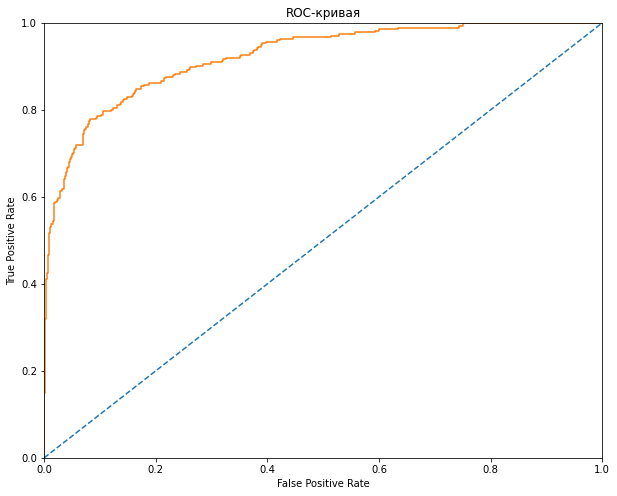

In [82]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities)
plt.figure(figsize=(10,8))
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr, tpr, linestyle='-')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Посмотрим на важность признаков при предсказании модели

In [84]:
pd.DataFrame({'feature':grid_cat.best_estimator_.named_steps['model'].feature_names_, 
              'importance':grid_cat.best_estimator_.named_steps['model'].feature_importances_})\
            .sort_values(by='importance', ascending=False)

,feature,importance
5,Duration,38.989005
3,MonthlyCharges,11.834382
4,TotalCharges,11.218103
0,Type,8.004445
2,PaymentMethod,6.902943
17,ServicesNumber,4.305070
7,Partner,3.034236
8,Dependents,2.147966
9,InternetService,2.130152
11,OnlineBackup,1.846638


Видим, что ключевым признаком для модели при прогнозировании факта оттока клиента является длительность действия договора, затем идут признаки, характеризующие ежемесячные и общие траты на услуги. Топ 5 закрывают тип оплаты и способ оплаты. 

In [85]:
matrix = pd.DataFrame(confusion_matrix(target_test, predict)).rename_axis(['answers'])
matrix.columns = pd.MultiIndex.from_product([['predictions'], matrix.columns])
matrix

predictions     
                  0    1
answers                 
0              1461   25
1               125  150

Наша модель правильно предсказала, что 1461 клиент не собираются прекращать сотрудничество с оператором, а 150 собираются уйти. При этом 125 клиента, которые хотели уйти, наша модель предсказала, что они не собираются уйти и 25 клиента по мнению модели собирались уйти, но на самом деле в планах у них такого не было. 

**ИТОГ.** В ходе итогового тестирования модель CatBoost показала метрику ROC-AUC 0.92 на тестовой выборке. Также рассмотрели важность признаков при предсказании моделью оттока клиентов, проанализировали матрицу ошибок.

## 6. Выводы

На основе данных о клиентах оператора связи «Ниединогоразрыва.ком» и услугах, которыми они пользовались (пользуются), было проведено исследование по прогнозированию оттока клиентов. В результате были выполнены следующие этапы исследования:
- загрузка и первичное ознокомление с данными;
- предобработка данных;
- исследовательский анализ данных;
- подготовка данных, обучение моделей и выбор из них наилучшей;
- итоговое тестирование выбранной модели.

На этапе предобработки данных были преодолены трудности, связанные с распределением всех необходимых данных по разным таблицам (путем объединения всех таблиц по уникальному идентификатору пользователя), неверным типом определенных признаков (путем изменения типа) и пропущенными значениями (путем заполнения пропусков). Возникла также проблема дисбаланса классов целевого признака, решенная тем, что в качестве метрики качества модели была взята AUC-ROC, не чувствительная к данной проблеме. Существовала проблема того, что значения количественных признаков находились в разных масштабах. Методом стандартизации данная проблема была решена. На последлок упомянем о проблеме категориальных признаков, которые мы не можем скормить 'деревянным' моделям и логистической регрессии. Данную проблему решили с помощью кодировщика признаков One-Hot Encoding. При этом бустинговые модели имеют свой встроенный кодировщик.

После проведения данного исследования можно обозначить ключевые шаги в решении задачи:
1. Выделение целевого признака `Termination`.
2. Объединение таблиц, содержащих информацию о договорах, персональных данных клиентов и услугах, предоставляемых оператором связи.
3. Подготовка данных к обучению модели.
4. Конфигурирование модели для предсказания оттока клиентов.

Для обучения модели использовались следующие признаки:
- `Duration` - этот признак означает длительность действия договора на момент выгрузки данных (изначально он не был в исходных данных и был получен путем вычета из даты окончания действия договора или даты выгрузки данных даты заключения договора);
- `MonthlyCharges` - признак, характеризующий ежемесячные траты клиентов на услуги (выполнялась только стандартизация этого признака);
- `TotalCharges` - общие траты клиентов за все время (выполнялось заполнение пропусков нулями, т.к. клиенты, которые только заключили договор, не успели потратить ничего, проводилось изменение типа данных в этом столбце, а также стандартизация признака);
- `Type` - тип оплаты (проводилось кодирование методом OHE для небустинговых моделей);
- `PaymentMethod` - способ оплаты (проводилось кодирование методом OHE для небустинговых моделей);
- `ServicesNumber` - количество дополнительных услуг, которыми пользуется (пользовался) клиент (в исходных наборах данных этого признака не было, был получен путем сложения количества дополнительных услуг, которыми пользуется клиент, данный признак был стандартизирован перед обучением моделей);
- `Partner` - наличие супруга(и) (проводилось кодирование методом OHE для небустинговых моделей);
- `Dependents` - наличие иждивенцев (проводилось кодирование методом OHE для небустинговых моделей);
- `InternetService` - тип интернет-услуг (осуществлялось заполнение пропусков после объединения таблиц, а также проводилось кодирование методом OHE для небустинговых моделей);
- `MultipleLines` - наличие возможности ведения параллельных линий во время звонка (осуществлялось заполнение пропусков после объединения таблиц, а также проводилось кодирование методом OHE для небустинговых моделей);
- `OnlineBackup` - наличие облачного хранилища файлов для резервного копирования данных (осуществлялось заполнение пропусков после объединения таблиц, а также проводилось кодирование методом OHE для небустинговых моделей);
- `SeniorCitizen` - наличие пенсионного статуса по возрасту (изменен тип данных, а также проводилось кодирование методом OHE для небустинговых моделей);
- `PaperlessBilling` - безналичный расчет (проводилось кодирование методом OHE для небустинговых моделей);
- `DeviceProtection` - наличие антивируса (осуществлялось заполнение пропусков после объединения таблиц, а также проводилось кодирование методом OHE для небустинговых моделей);
- `TechSupport` - наличие выделенной линии технической поддержки (осуществлялось заполнение пропусков после объединения таблиц, а также проводилось кодирование методом OHE для небустинговых моделей);
- `StreamingTV` - наличие стримингового телевидения (осуществлялось заполнение пропусков после объединения таблиц, а также проводилось кодирование методом OHE для небустинговых моделей);
- `OnlineSecurity` - наличие блокировки небезопасных сайтов (осуществлялось заполнение пропусков после объединения таблиц, а также проводилось кодирование методом OHE для небустинговых моделей);
- `StreamingMovies` - наличие каталога фильмов (осуществлялось заполнение пропусков после объединения таблиц, а также проводилось кодирование методом OHE для небустинговых моделей).

В качестве итоговой модели была выбрана модель CatBoost, показавшая метрику AUC-ROC на тестовой выборке 0.92. В данной модели использовались следующие значения гиперпараметров:
- iterations=500;
- learning_rate=0.2;
- random_state=50623.